# 🧠 CNN con Estimación de Incertidumbre (Epistémica + Aleatoria)

## Pipeline de Entrenamiento e Inferencia con Cuantificación de Incertidumbre

Este notebook implementa un modelo CNN con estimación de dos tipos de incertidumbre:

### 🎯 Tipos de Incertidumbre:
1. **Epistémica (modelo)**: Capturada con MC Dropout → reducible con más datos
2. **Aleatoria (datos)**: Capturada con cabeza de varianza → irreducible

### 📋 Pipeline:
1. **Setup**: Configuración del entorno
2. **Data Loading**: Carga de datos desde cache (augmentados)
3. **Split**: Train/Val/Test estratificado (70/15/15)
4. **Model**: CNN con DOS cabezas (predicción + ruido)
5. **Training**: Pérdida heteroscedástica con ruido gaussiano
6. **Evaluation**: MC Dropout para epistémica + σ² para aleatoria
7. **Visualization**: Histogramas, reliability plot, scatter

### 🏗️ Arquitectura:
- **Backbone**: 2× bloques Conv2D → BN → ReLU → MaxPool(3×3) → Dropout
- **Cabeza A**: Predicción (logits ∈ ℝ^C)
- **Cabeza B**: Ruido de datos (s_logit = log σ² ∈ ℝ^C, clamped [-10, 3])
- **MC Dropout**: Permanece activo en inferencia

### ⚙️ Entrenamiento:
- **Pérdida**: Heteroscedástica (log-likelihood con ruido gaussiano)
- **T_noise**: 5 muestras de ruido en entrenamiento
- **Optimizer**: AdamW (lr=1e-3, wd=1e-4)
- **Early stopping**: Por val_loss

### 🔬 Inferencia:
- **T_test**: 30-50 pasadas MC Dropout
- **Epistémica**: BALD = H(p̄) - mean H(p_t)
- **Aleatoria**: mean σ²_t
- **Total**: Entropía H(p̄)

### ⚠️ PREREQUISITO:
**Ejecutar primero `data_preprocessing.ipynb`** para generar el cache de datos preprocesados.


## 1. Setup y Configuración

In [24]:
# ============================================================
# IMPORTS Y CONFIGURACIÓN
# ============================================================
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# Agregar módulos propios al path
sys.path.insert(0, str(Path.cwd()))

# Importar módulos propios
from modules.augmentation import create_augmented_dataset
from modules.dataset import to_pytorch_tensors
from modules.uncertainty_model import UncertaintyCNN, print_uncertainty_model_summary
from modules.uncertainty_training import train_uncertainty_model, evaluate_with_uncertainty, print_uncertainty_results
from modules.uncertainty_visualization import (
    plot_uncertainty_histograms,
    plot_reliability_diagram,
    plot_uncertainty_scatter,
    plot_training_history_uncertainty
)
from modules.cnn_utils import plot_confusion_matrix

# Configuración de matplotlib
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Configuración de PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

# Reporte de configuración
print("="*70)
print("🧠 CNN CON ESTIMACIÓN DE INCERTIDUMBRE")
print("="*70)
print(f"✅ Librerías cargadas correctamente")
print(f"🔧 Dispositivo: {device}")
print(f"📦 PyTorch: {torch.__version__}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
print("="*70)

🧠 CNN CON ESTIMACIÓN DE INCERTIDUMBRE
✅ Librerías cargadas correctamente
🔧 Dispositivo: cpu
📦 PyTorch: 2.8.0+cpu


## 2. Carga de Datos

In [25]:
# ============================================================
# CONFIGURACIÓN DE RUTAS
# ============================================================

DATA_PATH_HEALTHY = "./data/vowels_healthy"
DATA_PATH_PARKINSON = "./data/vowels_pk"
CACHE_DIR_HEALTHY = "./cache/healthy"
CACHE_DIR_PARKINSON = "./cache/parkinson"

# Configuración de augmentation
AUGMENTATION_TYPES = ["original", "pitch_shift", "time_stretch", "noise"]
NUM_SPEC_AUGMENT_VERSIONS = 2

print("="*70)
print("📁 CARGANDO DATOS DESDE CACHE")
print("="*70)
print(f"\n⚙️  Configuración:")
print(f"   • Augmentation: {', '.join(AUGMENTATION_TYPES)}")
print(f"   • SpecAugment versions: {NUM_SPEC_AUGMENT_VERSIONS}")

📁 CARGANDO DATOS DESDE CACHE

⚙️  Configuración:
   • Augmentation: original, pitch_shift, time_stretch, noise
   • SpecAugment versions: 2


In [26]:
# ============================================================
# CARGAR DATOS HEALTHY
# ============================================================

print(f"\n🟢 CARGANDO HEALTHY...")
print("="*60)

audio_files_healthy = list(Path(DATA_PATH_HEALTHY).glob("*.egg"))
print(f"   Archivos encontrados: {len(audio_files_healthy)}")

augmented_dataset_healthy = create_augmented_dataset(
    audio_files_healthy,
    augmentation_types=AUGMENTATION_TYPES,
    apply_spec_augment=True,
    num_spec_augment_versions=NUM_SPEC_AUGMENT_VERSIONS,
    use_cache=True,
    cache_dir=CACHE_DIR_HEALTHY,
    force_regenerate=False,
    progress_every=5
)

X_healthy, y_task_healthy, y_domain_healthy, meta_healthy = to_pytorch_tensors(
    augmented_dataset_healthy
)

print(f"\n✅ Healthy cargado:")
print(f"   • Muestras: {X_healthy.shape[0]}")
print(f"   • Shape: {X_healthy.shape}")



🟢 CARGANDO HEALTHY...
   Archivos encontrados: 13
💾 Cargando dataset desde cache...
   📁 ./cache/healthy\augmented_dataset_c6631e32.pkl
✅ Cache cargado exitosamente: 1553 muestras
⚡ Tiempo ahorrado: ~6.5 min
📊 PyTorch tensors listos:
  - X: (1553, 1, 65, 41)
  - y_task: (1553,)  (dist={0: 1553})
  - y_domain: (1553,)  (K dominios=13)

✅ Healthy cargado:
   • Muestras: 1553
   • Shape: torch.Size([1553, 1, 65, 41])


In [27]:
# ============================================================
# CARGAR DATOS PARKINSON
# ============================================================

print(f"\n🔴 CARGANDO PARKINSON...")
print("="*60)

audio_files_parkinson = list(Path(DATA_PATH_PARKINSON).glob("*.egg"))
print(f"   Archivos encontrados: {len(audio_files_parkinson)}")

augmented_dataset_parkinson = create_augmented_dataset(
    audio_files_parkinson,
    augmentation_types=AUGMENTATION_TYPES,
    apply_spec_augment=True,
    num_spec_augment_versions=NUM_SPEC_AUGMENT_VERSIONS,
    use_cache=True,
    cache_dir=CACHE_DIR_PARKINSON,
    force_regenerate=False,
    progress_every=5
)

X_parkinson, y_task_parkinson, y_domain_parkinson, meta_parkinson = to_pytorch_tensors(
    augmented_dataset_parkinson
)

print(f"\n✅ Parkinson cargado:")
print(f"   • Muestras: {X_parkinson.shape[0]}")
print(f"   • Shape: {X_parkinson.shape}")



🔴 CARGANDO PARKINSON...
   Archivos encontrados: 13
💾 Cargando dataset desde cache...
   📁 ./cache/parkinson\augmented_dataset_c6631e32.pkl
✅ Cache cargado exitosamente: 1219 muestras
⚡ Tiempo ahorrado: ~6.5 min
📊 PyTorch tensors listos:
  - X: (1219, 1, 65, 41)
  - y_task: (1219,)  (dist={0: 1219})
  - y_domain: (1219,)  (K dominios=13)

✅ Parkinson cargado:
   • Muestras: 1219
   • Shape: torch.Size([1219, 1, 65, 41])


In [28]:
# ============================================================
# COMBINAR DATASETS
# ============================================================

print("\n" + "="*70)
print("🔗 COMBINANDO DATASETS")
print("="*70)

# Combinar espectrogramas
X_combined = torch.cat([X_healthy, X_parkinson], dim=0)

# Crear labels: 0=Healthy, 1=Parkinson
y_combined = torch.cat([
    torch.zeros(len(X_healthy), dtype=torch.long),
    torch.ones(len(X_parkinson), dtype=torch.long)
], dim=0)

print(f"\n📊 DATASET COMBINADO:")
print(f"   • Total muestras: {len(X_combined)}")
print(f"   • Shape: {X_combined.shape}")
print(f"   • Healthy (0): {(y_combined == 0).sum().item()} ({(y_combined == 0).sum()/len(y_combined)*100:.1f}%)")
print(f"   • Parkinson (1): {(y_combined == 1).sum().item()} ({(y_combined == 1).sum()/len(y_combined)*100:.1f}%)")

balance_pct = (y_combined == 1).sum() / len(y_combined) * 100
if abs(balance_pct - 50) < 10:
    print(f"   ✅ DATASET RAZONABLEMENTE BALANCEADO")
else:
    print(f"   ⚠️  DATASET DESBALANCEADO - considerar class weights")

print("="*70)



🔗 COMBINANDO DATASETS

📊 DATASET COMBINADO:
   • Total muestras: 2772
   • Shape: torch.Size([2772, 1, 65, 41])
   • Healthy (0): 1553 (56.0%)
   • Parkinson (1): 1219 (44.0%)
   ✅ DATASET RAZONABLEMENTE BALANCEADO


## 3. Split Train/Val/Test

Split estratificado 70/15/15 para mantener proporciones de clases.


In [29]:
# ============================================================
# SPLIT ESTRATIFICADO
# ============================================================

print("="*70)
print("📊 SPLIT TRAIN/VAL/TEST")
print("="*70)

# Split train/val/test (70/15/15)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_combined, y_combined,
    test_size=0.15,
    random_state=42,
    stratify=y_combined
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.176,  # 0.176 * 0.85 ≈ 0.15 del total
    random_state=42,
    stratify=y_train_val
)

print(f"\n📊 TAMAÑOS DE SPLITS:")
print(f"   • Train: {len(X_train)} ({len(X_train)/len(X_combined)*100:.1f}%)")
print(f"   • Val:   {len(X_val)} ({len(X_val)/len(X_combined)*100:.1f}%)")
print(f"   • Test:  {len(X_test)} ({len(X_test)/len(X_combined)*100:.1f}%)")

print(f"\n📊 DISTRIBUCIÓN POR SPLIT:")
for split_name, y_split in [("Train", y_train), ("Val", y_val), ("Test", y_test)]:
    n_healthy = (y_split == 0).sum().item()
    n_parkinson = (y_split == 1).sum().item()
    print(f"   {split_name:5s}: HC={n_healthy:4d} ({n_healthy/len(y_split)*100:.1f}%), PD={n_parkinson:4d} ({n_parkinson/len(y_split)*100:.1f}%)")

print("="*70)


📊 SPLIT TRAIN/VAL/TEST

📊 TAMAÑOS DE SPLITS:
   • Train: 1941 (70.0%)
   • Val:   415 (15.0%)
   • Test:  416 (15.0%)

📊 DISTRIBUCIÓN POR SPLIT:
   Train: HC=1087 (56.0%), PD= 854 (44.0%)
   Val  : HC= 233 (56.1%), PD= 182 (43.9%)
   Test : HC= 233 (56.0%), PD= 183 (44.0%)


In [30]:
# ============================================================
# CREAR DATALOADERS
# ============================================================

print("\n📦 CREANDO DATALOADERS...")

BATCH_SIZE = 128

# Clase wrapper para convertir tuplas en diccionarios
class DictDataset(torch.utils.data.Dataset):
    """Wrapper que convierte TensorDataset (tuplas) en diccionarios."""
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return {
            "spectrogram": self.X[idx],
            "label": self.y[idx]
        }

# Crear datasets con formato de diccionario
train_dataset = DictDataset(X_train, y_train)
val_dataset = DictDataset(X_val, y_val)
test_dataset = DictDataset(X_test, y_test)

# Crear DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE*2, shuffle=False, num_workers=0)

print(f"✅ DataLoaders creados:")
print(f"   • Train batches: {len(train_loader)}")
print(f"   • Val batches:   {len(val_loader)}")
print(f"   • Test batches:  {len(test_loader)}")
print(f"   • Batch size:    {BATCH_SIZE}")



📦 CREANDO DATALOADERS...
✅ DataLoaders creados:
   • Train batches: 16
   • Val batches:   2
   • Test batches:  2
   • Batch size:    128


## 4. Crear Modelo con Dos Cabezas

Modelo CNN con estimación de incertidumbre:
- **Backbone**: 2× bloques Conv2D → BN → ReLU → MaxPool → MCDropout
- **Cabeza A**: Predicción (logits)
- **Cabeza B**: Ruido de datos (s_logit para σ²)

In [31]:
# ============================================================
# CREAR MODELO CON INCERTIDUMBRE
# ============================================================

print("="*70)
print("🏗️  CREANDO MODELO CON INCERTIDUMBRE")
print("="*70)

# Hiperparámetros
DROPOUT_P = 0.25
S_MIN = -10.0
S_MAX = 3.0

# Crear modelo con dos cabezas
model = UncertaintyCNN(
    n_classes=2,
    p_drop_conv=DROPOUT_P,
    p_drop_fc=DROPOUT_P,
    input_shape=(65, 41),
    s_min=S_MIN,
    s_max=S_MAX
).to(device)

print(f"\n✅ Modelo creado en device: {device}")
print(f"\n⚙️  Hiperparámetros:")
print(f"   • Dropout: {DROPOUT_P}")
print(f"   • S clamp: [{S_MIN}, {S_MAX}]")

# Mostrar arquitectura
print_uncertainty_model_summary(model)

🏗️  CREANDO MODELO CON INCERTIDUMBRE

✅ Modelo creado en device: cpu

⚙️  Hiperparámetros:
   • Dropout: 0.25
   • S clamp: [-10.0, 3.0]

RESUMEN DEL MODELO CON INCERTIDUMBRE
UncertaintyCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): MCDropout2d()
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (9): MCDropout2d()
    (10): AdaptiveAvgPool2d(output_size=1)
    (11): Flatten(start_dim=1, end_dim=-1)
  )
  (head_logits): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1)

## 5. Entrenamiento con Pérdida Heteroscedástica

Entrenar con pérdida que modela ruido gaussiano en logits:
- Muestrea T_noise veces ruido ε ~ N(0,1)
- Logits ruidosos: x̂ = logits + σ ⊙ ε
- Maximiza log-likelihood esperado

In [32]:
# ============================================================
# CONFIGURAR ENTRENAMIENTO
# ============================================================

print("\n" + "="*70)
print("⚙️  CONFIGURACIÓN DE ENTRENAMIENTO")
print("="*70)

# Hiperparámetros
N_EPOCHS = 60
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
T_NOISE = 5  # Muestras de ruido en entrenamiento
EARLY_STOPPING_PATIENCE = 15

# Optimizer (AdamW con weight decay)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

# Directorio para guardar resultados
save_dir = Path("./results/cnn_uncertainty")
save_dir.mkdir(parents=True, exist_ok=True)

print(f"\n📋 Configuración:")
print(f"   • Épocas máximas: {N_EPOCHS}")
print(f"   • Learning rate: {LEARNING_RATE}")
print(f"   • Weight decay: {WEIGHT_DECAY}")
print(f"   • Optimizer: AdamW")
print(f"   • T_noise (train): {T_NOISE}")
print(f"   • Early stopping: {EARLY_STOPPING_PATIENCE} épocas")
print(f"   • Save dir: {save_dir}")
print("="*70)


⚙️  CONFIGURACIÓN DE ENTRENAMIENTO

📋 Configuración:
   • Épocas máximas: 60
   • Learning rate: 0.001
   • Weight decay: 0.0001
   • Optimizer: AdamW
   • T_noise (train): 5
   • Early stopping: 15 épocas
   • Save dir: results\cnn_uncertainty


In [ ]:
# ============================================================
# ENTRENAR MODELO
# ============================================================

print("\n" + "="*70)
print("🚀 INICIANDO ENTRENAMIENTO CON INCERTIDUMBRE")
print("="*70)

training_results = train_uncertainty_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    n_epochs=N_EPOCHS,
    n_noise_samples=T_NOISE,
    early_stopping_patience=EARLY_STOPPING_PATIENCE,
    save_dir=save_dir,
    verbose=True
)

# Extraer resultados
model = training_results["model"]
history = training_results["history"]
best_val_loss = training_results["best_val_loss"]
total_time = training_results["total_time"]

# Calcular mejor época
best_epoch = history["val_loss"].index(min(history["val_loss"])) + 1

print("\n" + "="*70)
print("✅ ENTRENAMIENTO COMPLETADO")
print("="*70)
print(f"\n📊 Resultados:")
print(f"   • Mejor época: {best_epoch}")
print(f"   • Mejor val loss: {best_val_loss:.4f}")
print(f"   • Tiempo total: {total_time/60:.1f} minutos")
print(f"   • Modelo guardado en: {save_dir / 'best_model_uncertainty.pth'}")
print("="*70)



🚀 INICIANDO ENTRENAMIENTO CON INCERTIDUMBRE

INICIO DE ENTRENAMIENTO CON INCERTIDUMBRE
Épocas máximas: 60
Early stopping patience: 15
T_noise (ruido en entrenamiento): 5
Device: cpu

Época   1/60 | Train Loss: 0.6716 | Train Acc: 0.6023 | Val Loss: 0.6906 | Val Acc: 0.5542 | Time: 14.5s
Época   2/60 | Train Loss: 0.6195 | Train Acc: 0.6646 | Val Loss: 0.6127 | Val Acc: 0.6482 | Time: 9.3s
Época   3/60 | Train Loss: 0.5678 | Train Acc: 0.7166 | Val Loss: 0.5507 | Val Acc: 0.7181 | Time: 8.8s
Época   4/60 | Train Loss: 0.5372 | Train Acc: 0.7372 | Val Loss: 0.5379 | Val Acc: 0.7012 | Time: 7.7s
Época   5/60 | Train Loss: 0.4897 | Train Acc: 0.7800 | Val Loss: 0.4983 | Val Acc: 0.7663 | Time: 7.6s
Época   6/60 | Train Loss: 0.4714 | Train Acc: 0.7944 | Val Loss: 0.4730 | Val Acc: 0.7759 | Time: 8.5s
Época   7/60 | Train Loss: 0.4628 | Train Acc: 0.7883 | Val Loss: 0.4565 | Val Acc: 0.7928 | Time: 6.2s
Época   8/60 | Train Loss: 0.4161 | Train Acc: 0.8078 | Val Loss: 0.4427 | Val Acc: 0.8

## 6. Evaluación con MC Dropout

Evaluar modelo con T_test pasadas de MC Dropout:
- **Epistémica**: BALD = H(p̄) - mean H(p_t)
- **Aleatoria**: mean σ²_t
- **Total**: Entropía H(p̄)


In [ ]:
# ============================================================
# EVALUACIÓN CON INCERTIDUMBRE EN TEST SET
# ============================================================

print("\n" + "="*70)
print("🎯 EVALUACIÓN CON INCERTIDUMBRE EN TEST SET")
print("="*70)

T_TEST = 30  # Número de pasadas MC Dropout

print(f"\n⚙️  T_test (MC Dropout): {T_TEST}")
print("\n🔄 Ejecutando MC Dropout...")

# Evaluar con incertidumbre
test_metrics = evaluate_with_uncertainty(
    model=model,
    loader=test_loader,
    device=device,
    n_mc_samples=T_TEST,
    class_names=["Healthy", "Parkinson"]
)

# Imprimir resultados
print_uncertainty_results(test_metrics, class_names=["Healthy", "Parkinson"])



🎯 EVALUACIÓN CON INCERTIDUMBRE EN TEST SET

⚙️  T_test (MC Dropout): 30

🔄 Ejecutando MC Dropout...

RESULTADOS CON INCERTIDUMBRE

📊 MÉTRICAS DE CLASIFICACIÓN:
  Accuracy:  0.9543
  Precision: 0.9524
  Recall:    0.9563
  F1-Score:  0.9539

📈 CALIBRACIÓN:
  NLL:         0.1796
  Brier Score: 0.0882
  ECE:         0.0974

🎲 INCERTIDUMBRES PROMEDIO:
  Entropía total (predictiva): 0.3292
  Epistémica (BALD):           0.0856
  Aleatoria (σ²):              0.0017

✅ ❌ INCERTIDUMBRE POR ACIERTO/ERROR:
  Entropía (correctos):   0.3143
  Entropía (incorrectos): 0.6397
  Epistémica (correctos):   0.0814
  Epistémica (incorrectos): 0.1727



In [ ]:
# ============================================================
# GUARDAR MÉTRICAS
# ============================================================

import json

metrics_to_save = {
    "accuracy": float(test_metrics["accuracy"]),
    "precision": float(test_metrics["precision"]),
    "recall": float(test_metrics["recall"]),
    "f1": float(test_metrics["f1"]),
    "nll": float(test_metrics["nll"]),
    "brier": float(test_metrics["brier"]),
    "ece": float(test_metrics["ece"]),
    "mean_entropy": float(test_metrics["mean_entropy"]),
    "mean_epistemic": float(test_metrics["mean_epistemic"]),
    "mean_aleatoric": float(test_metrics["mean_aleatoric"]),
    "entropy_correct": float(test_metrics["entropy_correct"]),
    "entropy_incorrect": float(test_metrics["entropy_incorrect"]),
    "epistemic_correct": float(test_metrics["epistemic_correct"]),
    "epistemic_incorrect": float(test_metrics["epistemic_incorrect"])
}

metrics_path = save_dir / "test_metrics_uncertainty.json"
with open(metrics_path, "w") as f:
    json.dump(metrics_to_save, f, indent=2)

print(f"\n💾 Métricas guardadas en: {metrics_path}")



💾 Métricas guardadas en: results\cnn_uncertainty\test_metrics_uncertainty.json


## 7. Visualización

Generar gráficas de:
1. Historial de entrenamiento
2. Histogramas de incertidumbres
3. Reliability diagram (calibración)
4. Scatter epistémica vs aleatoria
5. Matriz de confusión



📊 VISUALIZACIÓN: HISTORIAL DE ENTRENAMIENTO
💾 Historial guardado en: results\cnn_uncertainty\training_history.png


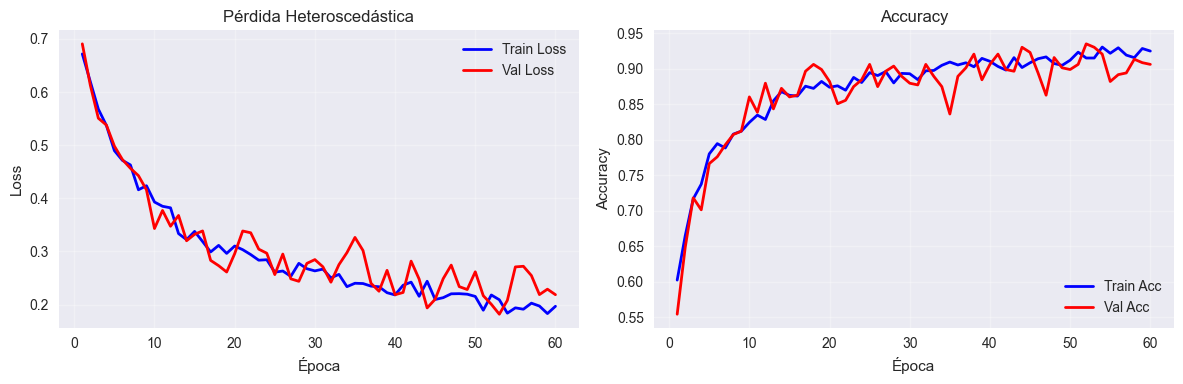


✅ Historial guardado en: results\cnn_uncertainty\training_history.png


In [ ]:
# ============================================================
# VISUALIZACIÓN: HISTORIAL DE ENTRENAMIENTO
# ============================================================

print("\n" + "="*70)
print("📊 VISUALIZACIÓN: HISTORIAL DE ENTRENAMIENTO")
print("="*70)

fig_history = plot_training_history_uncertainty(
    history,
    save_path=save_dir / "training_history.png",
    show=True
)

print(f"\n✅ Historial guardado en: {save_dir / 'training_history.png'}")



📊 VISUALIZACIÓN: HISTOGRAMAS DE INCERTIDUMBRES
💾 Histogramas guardados en: results\cnn_uncertainty\uncertainty_histograms.png


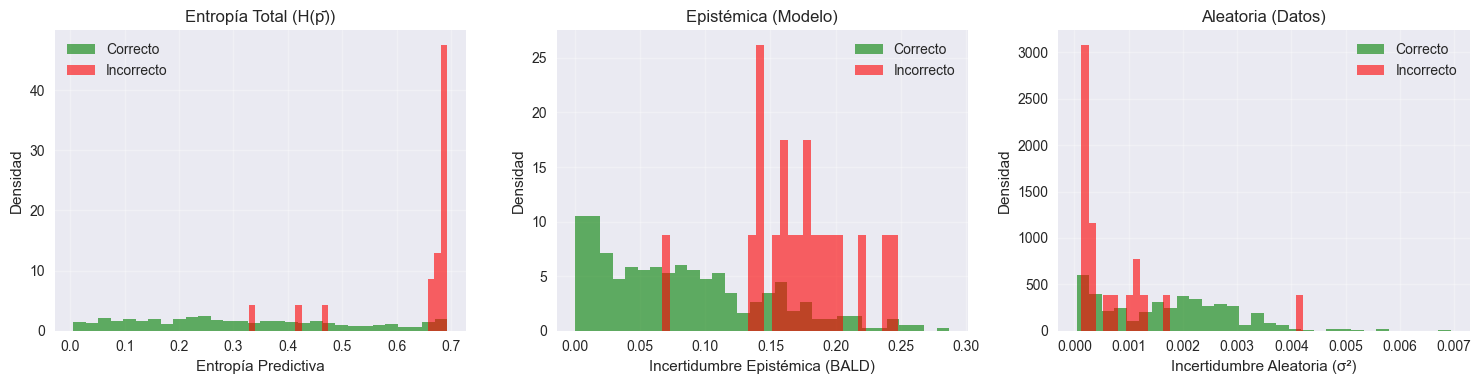


✅ Histogramas guardados en: results\cnn_uncertainty\uncertainty_histograms.png


In [ ]:
# ============================================================
# VISUALIZACIÓN: HISTOGRAMAS DE INCERTIDUMBRES
# ============================================================

print("\n" + "="*70)
print("📊 VISUALIZACIÓN: HISTOGRAMAS DE INCERTIDUMBRES")
print("="*70)

fig_hist = plot_uncertainty_histograms(
    test_metrics,
    save_path=save_dir / "uncertainty_histograms.png",
    show=True
)

print(f"\n✅ Histogramas guardados en: {save_dir / 'uncertainty_histograms.png'}")



📊 VISUALIZACIÓN: RELIABILITY DIAGRAM
💾 Diagrama de calibración guardado en: results\cnn_uncertainty\reliability_diagram.png


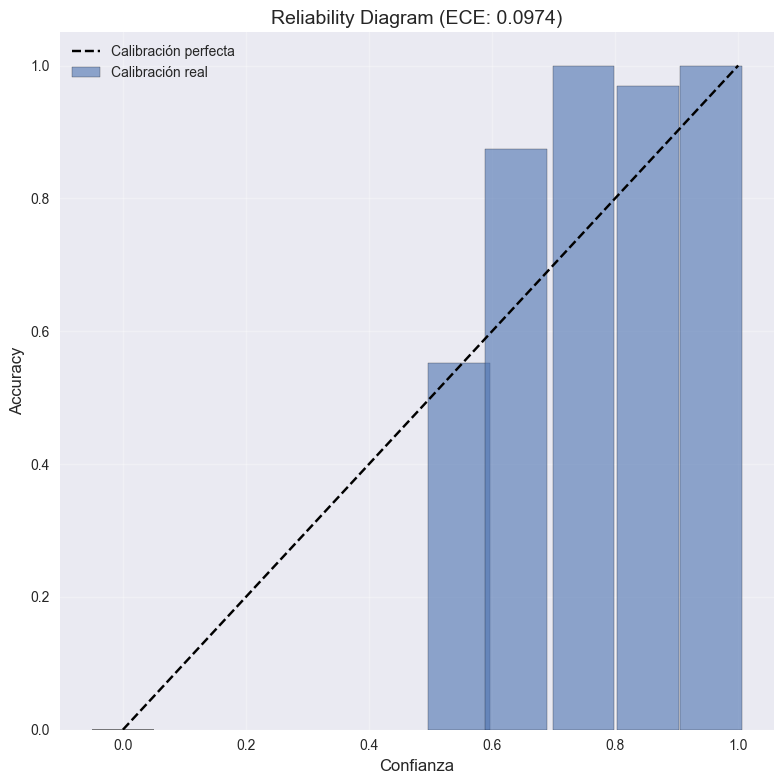


✅ Reliability diagram guardado en: results\cnn_uncertainty\reliability_diagram.png


In [ ]:
# ============================================================
# VISUALIZACIÓN: RELIABILITY DIAGRAM
# ============================================================

print("\n" + "="*70)
print("📊 VISUALIZACIÓN: RELIABILITY DIAGRAM")
print("="*70)

fig_rel = plot_reliability_diagram(
    test_metrics,
    n_bins=10,
    save_path=save_dir / "reliability_diagram.png",
    show=True
)

print(f"\n✅ Reliability diagram guardado en: {save_dir / 'reliability_diagram.png'}")



📊 VISUALIZACIÓN: SCATTER EPISTÉMICA VS ALEATORIA
💾 Scatter plot guardado en: results\cnn_uncertainty\uncertainty_scatter.png


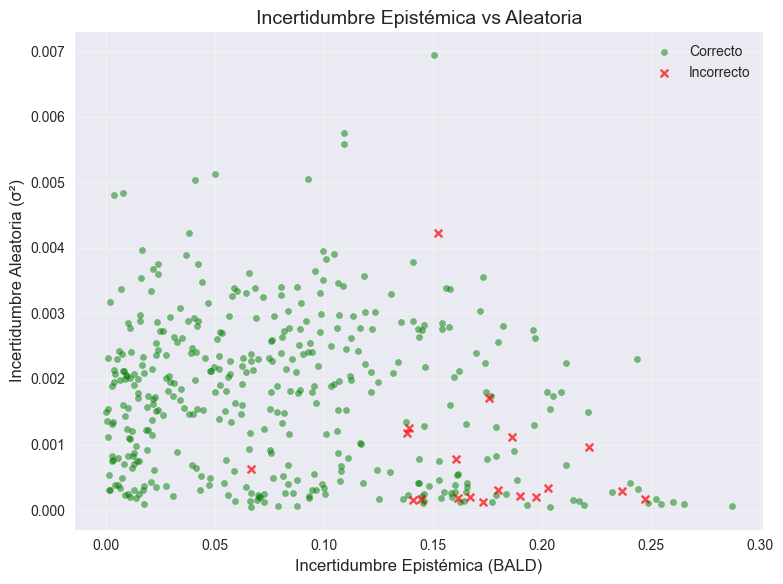


✅ Scatter guardado en: results\cnn_uncertainty\uncertainty_scatter.png


In [ ]:
# ============================================================
# VISUALIZACIÓN: SCATTER EPISTÉMICA VS ALEATORIA
# ============================================================

print("\n" + "="*70)
print("📊 VISUALIZACIÓN: SCATTER EPISTÉMICA VS ALEATORIA")
print("="*70)

fig_scatter = plot_uncertainty_scatter(
    test_metrics,
    save_path=save_dir / "uncertainty_scatter.png",
    show=True
)

print(f"\n✅ Scatter guardado en: {save_dir / 'uncertainty_scatter.png'}")



📊 VISUALIZACIÓN: MATRIZ DE CONFUSIÓN
💾 Matriz guardada en: results\cnn_uncertainty\confusion_matrix_test.png


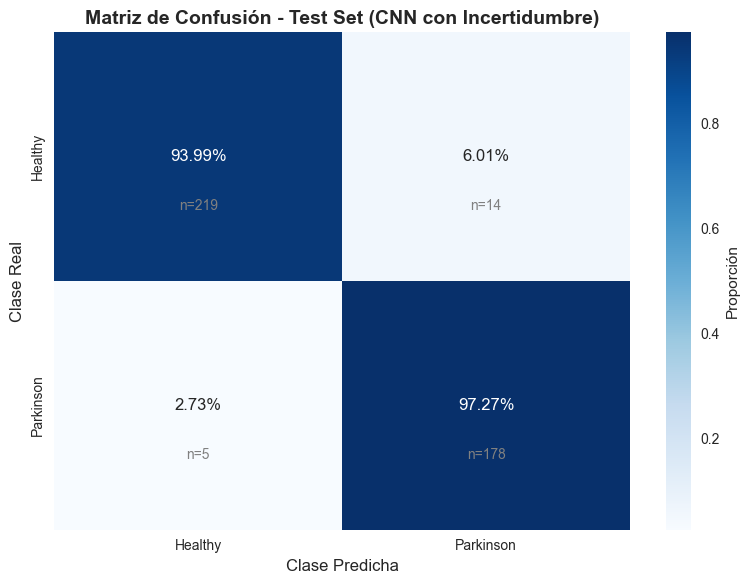


✅ Matriz de confusión guardada en: results\cnn_uncertainty\confusion_matrix_test.png


In [ ]:
# ============================================================
# VISUALIZACIÓN: MATRIZ DE CONFUSIÓN
# ============================================================

print("\n" + "="*70)
print("📊 VISUALIZACIÓN: MATRIZ DE CONFUSIÓN")
print("="*70)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_metrics["targets"], test_metrics["predictions"])

fig_cm = plot_confusion_matrix(
    cm,
    class_names=["Healthy", "Parkinson"],
    title="Matriz de Confusión - Test Set (CNN con Incertidumbre)",
    save_path=save_dir / "confusion_matrix_test.png",
    show=True
)

print(f"\n✅ Matriz de confusión guardada en: {save_dir / 'confusion_matrix_test.png'}")


## 📋 Resumen Final

### ✅ Completado:
1. **Datos**: Cargados desde cache (augmentados)
2. **Split**: Train/Val/Test estratificado (70/15/15)
3. **Modelo**: CNN con dos cabezas (predicción + ruido)
4. **Training**: Pérdida heteroscedástica con T_noise=5
5. **Evaluation**: MC Dropout (T_test=30) para epistémica + σ² para aleatoria
6. **Visualización**: Histogramas, reliability, scatter, confusión

### 🏗️ Arquitectura:
- **Backbone**: CNN con MC Dropout activo siempre
- **Cabeza A**: logits ∈ ℝ^C (predicción)
- **Cabeza B**: s_logit ∈ ℝ^C clamped [-10, 3] (log-varianza)

### 📊 Resultados Guardados:
- Modelo: `results/cnn_uncertainty/best_model_uncertainty.pth`
- Métricas: `results/cnn_uncertainty/test_metrics_uncertainty.json`
- Gráficas:
  * `training_history.png`
  * `uncertainty_histograms.png`
  * `reliability_diagram.png`
  * `uncertainty_scatter.png`
  * `confusion_matrix_test.png`

### 🎲 Tipos de Incertidumbre:
- **Total (H(p̄))**: Entropía predictiva
- **Epistémica (BALD)**: Incertidumbre del modelo (reducible con más datos)
- **Aleatoria (σ²)**: Ruido inherente de datos (irreducible)

### 📈 Métricas de Calibración:
- **NLL**: Negative Log-Likelihood
- **Brier Score**: Error cuadrático de probabilidades
- **ECE**: Expected Calibration Error


In [ ]:
# ============================================================
# RESUMEN FINAL
# ============================================================

print("\n" + "="*70)
print("📋 RESUMEN FINAL")
print("="*70)

print(f"\n🎯 MODELO: CNN con Estimación de Incertidumbre")
print(f"\n📊 DATASET:")
print(f"   • Total muestras: {len(X_combined)}")
print(f"   • Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

print(f"\n🏆 MEJOR MODELO (Época {best_epoch}):")
print(f"   • Val Loss: {best_val_loss:.4f}")

print(f"\n🎯 MÉTRICAS EN TEST SET:")
print(f"   • Accuracy:  {test_metrics['accuracy']:.4f}")
print(f"   • Precision: {test_metrics['precision']:.4f}")
print(f"   • Recall:    {test_metrics['recall']:.4f}")
print(f"   • F1-Score:  {test_metrics['f1']:.4f}")
print(f"   • NLL:       {test_metrics['nll']:.4f}")
print(f"   • Brier:     {test_metrics['brier']:.4f}")
print(f"   • ECE:       {test_metrics['ece']:.4f}")

print(f"\n🎲 INCERTIDUMBRES:")
print(f"   • Total (entropía):  {test_metrics['mean_entropy']:.4f}")
print(f"   • Epistémica (BALD): {test_metrics['mean_epistemic']:.4f}")
print(f"   • Aleatoria (σ²):    {test_metrics['mean_aleatoric']:.4f}")

print(f"\n✅ ❌ SEPARACIÓN POR ACIERTO:")
print(f"   • H (correctos):   {test_metrics['entropy_correct']:.4f}")
print(f"   • H (incorrectos): {test_metrics['entropy_incorrect']:.4f}")
print(f"   • Epi (correctos):   {test_metrics['epistemic_correct']:.4f}")
print(f"   • Epi (incorrectos): {test_metrics['epistemic_incorrect']:.4f}")

print(f"\n📁 Archivos guardados en: {save_dir}")
print(f"   ✓ best_model_uncertainty.pth")
print(f"   ✓ test_metrics_uncertainty.json")
print(f"   ✓ training_history.png")
print(f"   ✓ uncertainty_histograms.png")
print(f"   ✓ reliability_diagram.png")
print(f"   ✓ uncertainty_scatter.png")
print(f"   ✓ confusion_matrix_test.png")

print("\n" + "="*70)
print("✅ PIPELINE CON INCERTIDUMBRE COMPLETADO EXITOSAMENTE")
print("="*70)



📋 RESUMEN FINAL

🎯 MODELO: CNN con Estimación de Incertidumbre

📊 DATASET:
   • Total muestras: 2772
   • Train: 1941 | Val: 415 | Test: 416

🏆 MEJOR MODELO (Época 53):
   • Val Loss: 0.1820

🎯 MÉTRICAS EN TEST SET:
   • Accuracy:  0.9543
   • Precision: 0.9524
   • Recall:    0.9563
   • F1-Score:  0.9539
   • NLL:       0.1796
   • Brier:     0.0882
   • ECE:       0.0974

🎲 INCERTIDUMBRES:
   • Total (entropía):  0.3292
   • Epistémica (BALD): 0.0856
   • Aleatoria (σ²):    0.0017

✅ ❌ SEPARACIÓN POR ACIERTO:
   • H (correctos):   0.3143
   • H (incorrectos): 0.6397
   • Epi (correctos):   0.0814
   • Epi (incorrectos): 0.1727

📁 Archivos guardados en: results\cnn_uncertainty
   ✓ best_model_uncertainty.pth
   ✓ test_metrics_uncertainty.json
   ✓ training_history.png
   ✓ uncertainty_histograms.png
   ✓ reliability_diagram.png
   ✓ uncertainty_scatter.png
   ✓ confusion_matrix_test.png

✅ PIPELINE CON INCERTIDUMBRE COMPLETADO EXITOSAMENTE
